## Generative Latent Replay with GMMs

Code to test latent replay on benchmark problems and compare with proposed generative latent replay strategies i.e. normalising bottleneck representations and sampling from fitted GMM on latent space.

In [1]:
import random
import numpy as np
from matplotlib import pyplot as plt

# ML imports
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torchvision import transforms as T

from avalanche.training import Naive, Replay, plugins
from avalanche.benchmarks.classic import (
    RotatedMNIST,
    PermutedMNIST,
    PermutedOmniglot,
    RotatedOmniglot,
)

# Local imports
import utils
from models import SimpleCNN, SimpleMLP
from strategies import LatentReplay, GenerativeLatentReplay


In [2]:
# Config
device = utils.get_device()

# Dataset specific attributes
dataset = RotatedMNIST  # PermutedMNIST
n_classes = 10
n_experiences = 3

# Model specification
model = "mlp"
hidden_size = 64
n_hidden_layers = 4

# Frozen backbone
freeze_depth = 2  # assert freeze_depth <= n_hidden_layers
if model == "mlp":
    latent_layer_number = freeze_depth * 3
elif model == "cnn":
    latent_layer_number = freeze_depth * 2

# Hyperparams
lr = 0.001
l2 = 0.0005
momentum = 0.9

n_epochs = 20
train_mb_size = 128
eval_mb_size = 512

replay_buffer_size = 5000
cl_plugins = None  # [plugins.EarlyStoppingPlugin(patience=1, val_stream_name="train_stream")]  # JA: need to set params

eval_every = -1

# Reproducibility
SEED = 109
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [3]:
# Model
n = 6

if model == "mlp":
    networks = [SimpleMLP(n_classes, hidden_size, n_hidden_layers) for i in range(n)]
    transform = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])

elif model == "cnn":
    networks = [SimpleCNN(n_classes, hidden_size, n_hidden_layers) for i in range(n)]
    transform = T.Compose([T.ToTensor()])


c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [4]:
# Continual learning strategy
gen_lat_replay_strategy = GenerativeLatentReplay(
    model=networks[4],
    rm_sz=replay_buffer_size,
    train_mb_size=train_mb_size,
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    latent_layer_num=latent_layer_number,
    device=device,
    eval_every=eval_every,
    plugins=cl_plugins,
)

gen_replay_strategy = GenerativeLatentReplay(
    model=networks[5],
    rm_sz=replay_buffer_size,
    train_mb_size=train_mb_size,
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    latent_layer_num=0,
    device=device,
    eval_every=eval_every,
    plugins=cl_plugins,
)

In [5]:
naive_strategy = Naive(
    model=networks[0],
    optimizer=SGD(networks[0].parameters(), lr=lr, momentum=momentum, weight_decay=l2),
    train_mb_size=train_mb_size,
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    device=device,
    eval_every=eval_every,
)

replay_strategy = Replay(
    model=networks[1],
    optimizer=SGD(networks[1].parameters(), lr=lr, momentum=momentum, weight_decay=l2),
    train_mb_size=train_mb_size,
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    device=device,
    criterion=CrossEntropyLoss(),
    eval_every=eval_every,
    plugins=cl_plugins,
)

In [6]:
# Sanity check - shuld perform similar to "Replay"
replay_thawed_strategy = LatentReplay(
    model=networks[2],
    rm_sz=replay_buffer_size,
    train_mb_size=train_mb_size,
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    latent_layer_num=0,
    device=device,
    subsample_replays=True,
    eval_every=eval_every,
    plugins=cl_plugins,
)

lat_replay_strategy = LatentReplay(
    model=networks[3],
    rm_sz=replay_buffer_size,
    train_mb_size=train_mb_size,
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    latent_layer_num=latent_layer_number,
    device=device,
    subsample_replays=True,
    eval_every=eval_every,
    plugins=cl_plugins,
)

In [12]:
strategies = {
    #"Naive": {"model": naive_strategy, "results": []},
    #"Replay": {"model": replay_strategy, "results": []},
    #"Replay (re-imp)": {"model": replay_thawed_strategy, "results": []},
    "Latent Replay": {"model": lat_replay_strategy, "results": []},
    #"Generative Replay": {"model": gen_replay_strategy, "results": []},
    "Generative Latent Replay": {"model": gen_lat_replay_strategy, "results": []},
}

In [13]:
for strategy in strategies.keys():
    experiences = dataset(
        n_experiences=n_experiences,
        train_transform=transform,
        eval_transform=transform,
        seed=SEED,
        rotations_list=[0, 60, 300],
    )
    train_stream = experiences.train_stream
    test_stream = experiences.test_stream

    for train_exp in train_stream:
        strategies[strategy]["model"].train(train_exp)
        strategies[strategy]["results"].append(
            strategies[strategy]["model"].eval(train_stream)
        )


-- >> Start of training phase << --
100%|██████████| 938/938 [00:26<00:00, 35.58it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.3141
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5314
100%|██████████| 938/938 [00:23<00:00, 39.67it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.2711
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5579
100%|██████████| 938/938 [00:50<00:00, 18.74it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.2446
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5726
100%|██████████| 938/938 [00:27<00:00, 33.67it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.2245
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5816
100%|██████████| 938/938 [00:23<00:00, 39.27it/s]
Epoch 4 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.2090
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5882
100%|██████████| 938/938 [00:23<00:00, 39.51it/s]
Epoch 5 ended.
	Loss_Epoch/tr

c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\sklearn\mixture\_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Generator trained.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from train stream --
100%|██████████| 118/118 [00:18<00:00,  6.55it/s]
> Eval on experience 0 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp000 = 0.2994
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp000 = 0.9183
-- Starting eval on experience 1 (Task 0) from train stream --
100%|██████████| 118/118 [00:15<00:00,  7.59it/s]
> Eval on experience 1 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp001 = 3.5086
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp001 = 0.2298
-- Starting eval on experience 2 (Task 0) from train stream --
100%|██████████| 118/118 [00:15<00:00,  7.53it/s]
> Eval on experience 2 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp002 = 3.7080
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp002 = 0.2172
-- >> End of eval phase << --
	Loss_Stream/ev

c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\sklearn\mixture\_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Generator trained.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from train stream --
100%|██████████| 118/118 [00:13<00:00,  8.92it/s]
> Eval on experience 0 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp000 = 1.9140
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp000 = 0.3297
-- Starting eval on experience 1 (Task 0) from train stream --
100%|██████████| 118/118 [00:15<00:00,  7.66it/s]
> Eval on experience 1 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp001 = 1.0261
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp001 = 0.6783
-- Starting eval on experience 2 (Task 0) from train stream --
100%|██████████| 118/118 [00:14<00:00,  8.11it/s]
> Eval on experience 2 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp002 = 3.1996
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp002 = 0.1262
-- >> End of eval phase << --
	Loss_Stream/ev

c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\sklearn\mixture\_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Generator trained.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from train stream --
100%|██████████| 118/118 [00:12<00:00,  9.45it/s]
> Eval on experience 0 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp000 = 1.6206
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp000 = 0.4320
-- Starting eval on experience 1 (Task 0) from train stream --
100%|██████████| 118/118 [00:13<00:00,  8.63it/s]
> Eval on experience 1 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp001 = 2.4400
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp001 = 0.2118
-- Starting eval on experience 2 (Task 0) from train stream --
100%|██████████| 118/118 [00:13<00:00,  8.61it/s]
> Eval on experience 2 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp002 = 0.9755
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp002 = 0.7165
-- >> End of eval phase << --
	Loss_Stream/ev

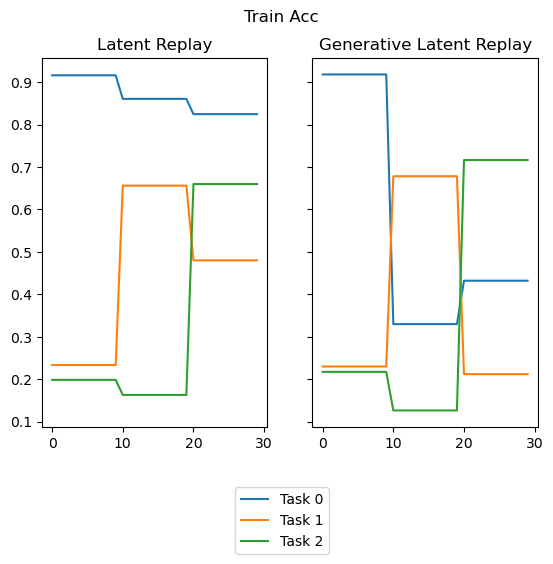

In [32]:
import importlib
importlib.reload(utils)

fig, axes = plt.subplots(1, (len(strategies)), sharey="row")

utils.plot_multiple_results(
    [s["results"] for s in strategies.values()],
    strategies.keys(),
    axes,
    fig,
    n_experiences,
)
